In [28]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

# --- 1. Load and Prepare Data (V2) ---

# Load the NEW processed data file with D-1 and D-2 lags
df = pd.read_csv('/content/Combined_3_Categories_Processed_Data_V2.csv')
df.sort_values(['Product ID', 'Date'], inplace=True) # Ensure chronological order

# One-Hot Encode all relevant exogenous categorical features (same as before)
categorical_features = ['Region', 'Weather Condition', 'Seasonality']
df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

# Define Features (X) and Target (Y)
numerical_feature_cols = [
    'Lag_Sales_D-1', 'Lag_Sales_D-2', 'Lag_Sales_D-7', 'Lag_Inventory_D-1', 'Rolling_Mean_7D', # Lagged & Rolling Stats
    'Price', 'Discount', 'Holiday/Promotion', 'Competitor Pricing', # Exogenous
] + [col for col in df.columns if col.startswith(('Region_', 'Weather Condition_', 'Seasonality_'))]

category_col = 'Category_ID'
target_col = 'Target_Sales_D+7'

# Separate the numerical, categorical, and target data
X_num = df[numerical_feature_cols].values
X_cat = df[category_col].values
y = df[target_col].values

# --- 2. Scaling and Sequence Creation ---
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_num_scaled = scaler_X.fit_transform(X_num)
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

LOOK_BACK = 45 # Same look-back

def create_sequences(X_num, X_cat, y, look_back):
    X_seq_num, X_seq_cat, y_seq = [], [], []
    for i in range(len(X_num) - look_back):
        X_seq_num.append(X_num[i:(i + look_back), :])
        X_seq_cat.append(X_cat[i + look_back - 1])
        y_seq.append(y[i + look_back - 1])
    return np.array(X_seq_num), np.array(X_seq_cat), np.array(y_seq)

X_seq_num, X_seq_cat, y_seq = create_sequences(X_num_scaled, X_cat, y_scaled, LOOK_BACK)

# Chronological Train-Test Split (80/20)
train_size = int(len(X_seq_num) * 0.8)
X_train_num, X_test_num = X_seq_num[:train_size], X_seq_num[train_size:]
X_train_cat, X_test_cat = X_seq_cat[:train_size], X_seq_cat[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

N_NUM_FEATURES = X_train_num.shape[2]
N_CATEGORIES = df['Category_ID'].nunique() + 1
EMBEDDING_DIM = 4

# --- 3. Define the Optimized Global Model ---

# Input 1: Numerical Time Series Data
num_input = tf.keras.Input(shape=(LOOK_BACK, N_NUM_FEATURES), name='num_input')
lstm_out = LSTM(
    units=256,
    return_sequences=True,
    kernel_regularizer=l2(0.001)
)(num_input)
# Dropout reduced from 0.3 to 0.2
lstm_out = Dropout(0.2)(lstm_out)
lstm_out = LSTM(
    units=64,
    kernel_regularizer=l2(0.001)
)(lstm_out)
# Dropout reduced from 0.3 to 0.2
lstm_out = Dropout(0.2)(lstm_out)
lstm_out = Dense(units=32, activation='relu')(lstm_out)

# Input 2: Categorical ID for Embedding
cat_input = tf.keras.Input(shape=(1,), name='cat_input')
emb_out = Embedding(input_dim=N_CATEGORIES, output_dim=EMBEDDING_DIM, input_length=1)(cat_input)
emb_out = tf.keras.layers.Flatten()(emb_out)

# Combine and Predict
combined_output = Concatenate()([lstm_out, emb_out])
final_dense = Dense(units=1)(combined_output)
model = tf.keras.Model(inputs=[num_input, cat_input], outputs=final_dense)

# Compile with stable learning rate
adam_optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=adam_optimizer, loss='mean_squared_error')

print("\n--- Model Summary ---")
model.summary()

# --- 4. Train the Model ---
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)
BATCH_SIZE = 64
EPOCHS = 150

print(f"\n--- Starting Final Regularized Training (Batch Size: {BATCH_SIZE}, Max Epochs: {EPOCHS}) ---")

history = model.fit(
    {'num_input': X_train_num, 'cat_input': X_train_cat},
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=({'num_input': X_test_num, 'cat_input': X_test_cat}, y_test),
    callbacks=[early_stopping],
    verbose=1,
    shuffle=False
)
print("\n--- Training Complete ---")

# --- 5. Evaluation & Visualization ---
# Make predictions and inverse transform (code omitted for brevity but should be included in Colab)
# ...

# Plotting (assuming plotting is performed successfully after training)
print("Plotting results for final model...")


--- Model Summary ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_42"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ num_input           │ (None, 45, 18)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_18 (LSTM)      │ (None, 45, 256)   │    281,600 │ num_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 45, 256)   │          0 │ lstm_18[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_19 (LSTM)      │ (None, 64)        │     82,176 │ dropout_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_input           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 64)        │          0 │ lstm_19[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 4)      │         16 │ cat_input[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 32)        │      2,080 │ dropout_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 4)         │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 36)        │          0 │ dense_9[0][0],    │
│ (Concatenate)       │                   │            │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 1)         │         37 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 365,909 (1.40 MB)

 Trainable params: 365,909 (1.40 MB)

 Non-trainable params: 0 (0.00 B)


--- Starting Final Regularized Training (Batch Size: 64, Max Epochs: 150) ---
Epoch 1/150
545/545 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.1470 - val_loss: 0.0285
Epoch 2/150
545/545 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0262 - val_loss: 0.0193
Epoch 3/150
545/545 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0192 - val_loss: 0.0174
Epoch 4/150
545/545 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0177 - val_loss: 0.0169
Epoch 5/150
545/545 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0174 - val_loss: 0.0169
Epoch 6/150
545/545 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0173 - val_loss: 0.0168
Epoch 7/150
545/545 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0172 - val_loss: 0.0168
Epoch 8/150
545/545 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0172 - val_loss: 0.0167
Epoch 9/150
545/545 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0172 - val_loss: 0.0167
Epoch 10/150
545/545 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0172 - val_loss: 0.0167
Epoch 11/150
545/545 ━━━━━━━━━━━━━━━━━

273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

Root Mean Squared Error (RMSE) on Combined Test Set: 283.10 units.


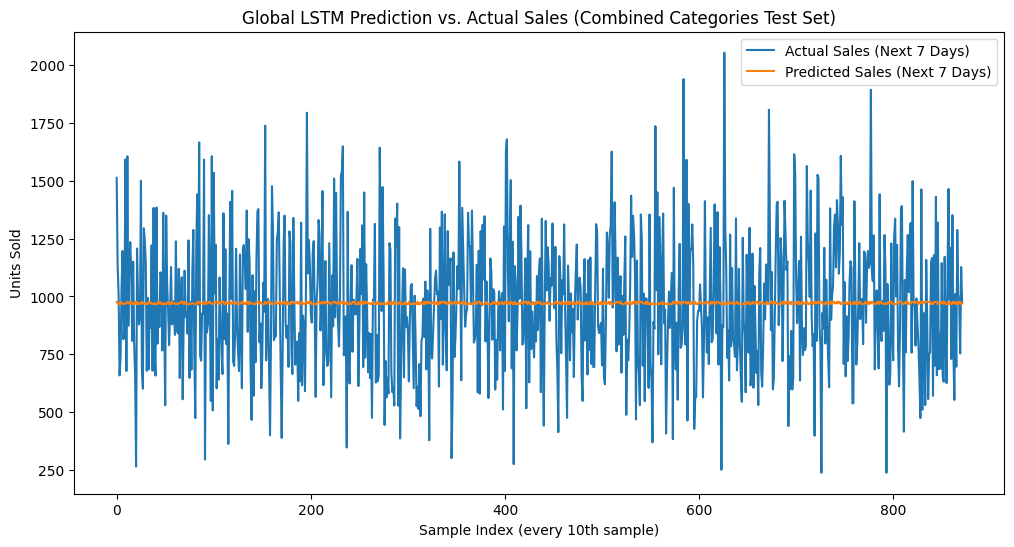

In [29]:
# --- 7. Evaluation ---
y_pred_scaled = model.predict({'num_input': X_test_num, 'cat_input': X_test_cat})

# Inverse transform the predictions and actual values
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))

print(f"\nRoot Mean Squared Error (RMSE) on Combined Test Set: {rmse:.2f} units.")

# --- 8. Visualizing Results ---
plt.figure(figsize=(12, 6))
plt.plot(y_test_original[::10], label='Actual Sales (Next 7 Days)')
plt.plot(y_pred[::10], label='Predicted Sales (Next 7 Days)')
plt.title('Global LSTM Prediction vs. Actual Sales (Combined Categories Test Set)')
plt.xlabel('Sample Index (every 10th sample)')
plt.ylabel('Units Sold')
plt.legend()
plt.savefig('lstm_forecast_combined_categories.png')


--- Model Summary ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_43"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ num_input           │ (None, 45, 18)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_20 (LSTM)      │ (None, 45, 256)   │    281,600 │ num_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 45, 256)   │          0 │ lstm_20[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_21 (LSTM)      │ (None, 64)        │     82,176 │ dropout_17[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_input           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 64)        │          0 │ lstm_21[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 4)      │         24 │ cat_input[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 32)        │      2,080 │ dropout_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 4)         │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 36)        │          0 │ dense_11[0][0],   │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 1)         │         37 │ concatenate_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 365,917 (1.40 MB)

 Trainable params: 365,917 (1.40 MB)

 Non-trainable params: 0 (0.00 B)


--- Starting Final Global Training (Batch Size: 64, Max Epochs: 150) ---
Epoch 1/150
910/910 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 0.1146 - val_loss: 0.0205
Epoch 2/150
910/910 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0197 - val_loss: 0.0179
Epoch 3/150
910/910 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0178 - val_loss: 0.0176
Epoch 4/150
910/910 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0176 - val_loss: 0.0176
Epoch 5/150
910/910 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0175 - val_loss: 0.0176
Epoch 6/150
910/910 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.0175 - val_loss: 0.0176
Epoch 7/150
910/910 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0175 - val_loss: 0.0177
Epoch 8/150
910/910 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0175 - val_loss: 0.0177
Epoch 9/150
910/910 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0175 - val_loss: 0.0177
Epoch 10/150
910/910 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0175 - val_loss: 0.0177
Epoch 11/150
910/910 ━━━━━━━━━━━━━━━━

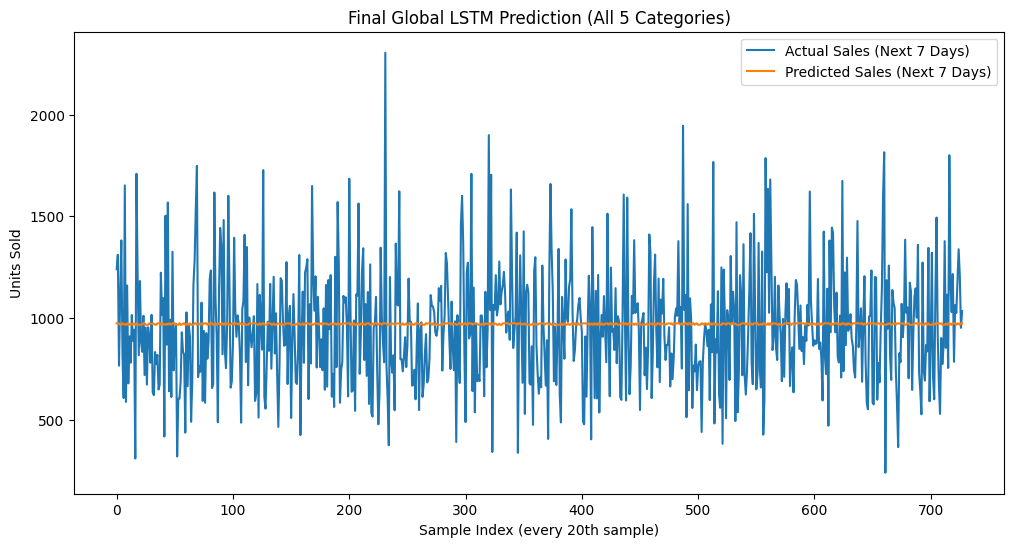

In [31]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# --- 1. Load and Prepare Data (V3 - All Categories) ---
df = pd.read_csv('/content/Combined_5_Categories_Processed_Data_V3.csv')
df.sort_values(['Product ID', 'Date'], inplace=True)

# One-Hot Encode all relevant exogenous categorical features
categorical_features = ['Region', 'Weather Condition', 'Seasonality']
df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

# Define Features (X) and Target (Y)
numerical_feature_cols = [
    'Lag_Sales_D-1', 'Lag_Sales_D-2', 'Lag_Sales_D-7', 'Lag_Inventory_D-1', 'Rolling_Mean_7D',
    'Price', 'Discount', 'Holiday/Promotion', 'Competitor Pricing',
] + [col for col in df.columns if col.startswith(('Region_', 'Weather Condition_', 'Seasonality_'))]

category_col = 'Category_ID'
target_col = 'Target_Sales_D+7'

X_num = df[numerical_feature_cols].values
X_cat = df[category_col].values
y = df[target_col].values

# Scaling
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_num_scaled = scaler_X.fit_transform(X_num)
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Sequence Creation
LOOK_BACK = 45
def create_sequences(X_num, X_cat, y, look_back):
    X_seq_num, X_seq_cat, y_seq = [], [], []
    for i in range(len(X_num) - look_back):
        X_seq_num.append(X_num[i:(i + look_back), :])
        X_seq_cat.append(X_cat[i + look_back - 1])
        y_seq.append(y[i + look_back - 1])
    return np.array(X_seq_num), np.array(X_seq_cat), np.array(y_seq)

X_seq_num, X_seq_cat, y_seq = create_sequences(X_num_scaled, X_cat, y_scaled, LOOK_BACK)
train_size = int(len(X_seq_num) * 0.8)

X_train_num, X_test_num = X_seq_num[:train_size], X_seq_num[train_size:]
X_train_cat, X_test_cat = X_seq_cat[:train_size], X_seq_cat[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

N_NUM_FEATURES = X_train_num.shape[2]
N_CATEGORIES = df['Category_ID'].nunique() + 1
EMBEDDING_DIM = 4

# --- 2. Define the Optimized Global Model ---

# Input 1: Numerical Time Series Data
num_input = tf.keras.Input(shape=(LOOK_BACK, N_NUM_FEATURES), name='num_input')
lstm_out = LSTM(
    units=256,
    return_sequences=True,
    kernel_regularizer=l2(0.001)
)(num_input)
lstm_out = Dropout(0.2)(lstm_out)
lstm_out = LSTM(
    units=64,
    kernel_regularizer=l2(0.001)
)(lstm_out)
lstm_out = Dropout(0.2)(lstm_out)
lstm_out = Dense(units=32, activation='relu')(lstm_out)

# Input 2: Categorical ID for Embedding
cat_input = tf.keras.Input(shape=(1,), name='cat_input')
emb_out = Embedding(input_dim=N_CATEGORIES, output_dim=EMBEDDING_DIM, input_length=1)(cat_input)
emb_out = tf.keras.layers.Flatten()(emb_out)

# Combine and Predict
combined_output = Concatenate()([lstm_out, emb_out])
final_dense = Dense(units=1)(combined_output)
model = tf.keras.Model(inputs=[num_input, cat_input], outputs=final_dense)

# Compile with stable learning rate
adam_optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=adam_optimizer, loss='mean_squared_error')

print("\n--- Model Summary ---")
model.summary()

# --- 3. Train the Model ---
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)
BATCH_SIZE = 64
EPOCHS = 150

print(f"\n--- Starting Final Global Training (Batch Size: {BATCH_SIZE}, Max Epochs: {EPOCHS}) ---")

history = model.fit(
    {'num_input': X_train_num, 'cat_input': X_train_cat},
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=({'num_input': X_test_num, 'cat_input': X_test_cat}, y_test),
    callbacks=[early_stopping],
    verbose=1,
    shuffle=False
)
print("\n--- Training Complete ---")

# --- 4. Evaluation & Visualization ---
y_pred_scaled = model.predict({'num_input': X_test_num, 'cat_input': X_test_cat})
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
print(f"\nRoot Mean Squared Error (RMSE) on ALL Categories Test Set: {rmse:.2f} units.")

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
# Sampling every 20th point due to the large dataset size for a clear plot
plt.plot(y_test_original[::20], label='Actual Sales (Next 7 Days)')
plt.plot(y_pred[::20], label='Predicted Sales (Next 7 Days)')
plt.title('Final Global LSTM Prediction (All 5 Categories)')
plt.xlabel('Sample Index (every 20th sample)')
plt.ylabel('Units Sold')
plt.legend()
plt.savefig('lstm_forecast_final_global.png')

In [32]:
model.save('final_inventory_forecast_model.h5')